## Group Work 2: Predict marketing campaign success

** context **

You have been contacted by a banking institution that is willing to leverage its data to improve its telemarketing strategy. <br>

As it wants to decrease its exposure to international credit markets, the bank decided to launch a telemarketing campaign in order to increase the amount of clients' deposits. Higher level of deposits means lower needs to borrow money on credit markets.<br> 

The bank has accumulated data from previous telemarketing campaigns and asks you to analyse it to assess whether you can predict which customers are likely to submit a new deposit. If your analysis enables to identify high potential clients, it will allow the bank to allocate its efforts on highest potential clients. <br>

In order to tackle that challenge you decided to use machine learning algorithms that you have learned in Data Management & Analytics classes.

** data **

The dataset includes information about calls that took place during previous telemarketing campaigns.

- age: age of the client
- balance: balance on the client's account (€)
- campaign: number of contacts performed during this campaign and for this client
- day: day of the month when the call took place
- default: whether the client credit in default ('yes':1, 'no':0)
- duration: last call duration
- education: client's education ('tertiary', 'secondary', 'unknown', 'primary')
- housing: whether the client has housing loan ('yes':1, 'no':0)
- loan: whether the client has personal loan ('yes':1, 'no':0)
- marital: marital status('married':1, 'not married':0)
- previous: number of contacts performed before this campaign and for this client
- poutcome: outcome of the previous marketing campaign
- subscription: whether the client subscribed to a term deposit after the call ('yes':1, 'no':0).

** Simply run the following lines to connect to MongoDB database and import python libraries **

In [1]:
from pymongo import MongoClient
client = MongoClient()
db = client['Solvay']
import matplotlib.pyplot as plt
from IPython.display import Image
import pydotplus
from sklearn import tree
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score

** Simply run the following lines to import data in a MongoDB collection named 'direct_calls' **

In [2]:
from Import import ImportDirectCalls
ImportDirectCalls = ImportDirectCalls()
ImportDirectCalls.import_data()

### A. Data preparation

** A.1 Select a document from 'direct_calls' collection to have a look at the data **

In [3]:
db['direct_calls'].find_one()

{u'_id': ObjectId('60707dd901651c0b075efc8e'),
 u'age': 58,
 u'balance': 2143,
 u'campaign': 1,
 u'day': 5,
 u'default': 0,
 u'duration': 261,
 u'education': u'tertiary',
 u'housing': 1,
 u'is_employee': 0,
 u'is_entrepreneur': 0,
 u'is_manager': 1,
 u'is_retired': 0,
 u'is_student': 0,
 u'is_unemployed': 0,
 u'job': u'management',
 u'loan': 0,
 u'marital': 1,
 u'poutcome': u'unknown',
 u'poutcome_is_failure': 0,
 u'poutcome_is_success': 0,
 u'poutcome_is_unknown': 1,
 u'previous': 0,
 u'subscription': 0}

In [10]:
db['direct_calls'].find().count()

45211

** A.2 Which variable will you use as output value to perform the supervised learning task ? ** <br>
Just name it

subscription

** A.3 Create a list of strings named variables containing features to include in your model ** <br>
Select all features that can be used as input in sklearn

In [4]:
variables = ['age','balance','campaign', 'day', 'default','duration', 'housing','is_employee', 'is_entrepreneur','is_manager', 'is_retired', 'is_student','is_unemployed','loan', 'marital','poutcome_is_failure', 'poutcome_is_success', 'poutcome_is_unknown', 'previous'  ]

** A.4 Complete the following code to generate a training sample and a testing sample, using a 50/50 split ** <br>

In [6]:
features_train = []
target_train = []
features_test = []
target_test = []

direct_calls_all = db['direct_calls'].find()
count = 0
for call in direct_calls_all:
    count += 1
    call_features = []
    for feature in variables:
        call_features.append(call[feature])
    if None not in call and '' not in call_features:
        if count % 2 != 0:
            features_train.append(call_features)
            target_train.append(call['subscription'])
        elif count % 2 == 0:
            features_test.append(call_features)
            target_test.append(call['subscription'])

In [7]:
len(features_train)

22606

In [12]:
len(target_train)

22606

In [13]:
target_train.count(1)

3099

In [14]:
target_train.count(0)

19507

** A.5 Explain why we use training and testing samples in supervised learning tasks ? ** <br>

The train dataset is used to build the model while the test sample is used to evaluate if the model generalises well on new sample

### B. Train and evaluate decision tree classifiers

** B.1 Train a decision tree on the training sample **

- using entropy to measure the quality of a split
- having a maximum depth of 1
- requiring at least 0.5% of the sample to split an internal node

In [15]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=1, min_samples_split=0.5)
clf_fit = clf.fit(features_train, target_train)

** Run the following lines to visualise the result of B.1 **

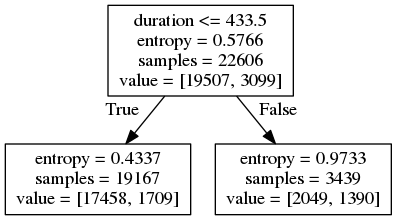

In [16]:
tree.export_graphviz(clf_fit, out_file="tree.dot", feature_names=variables)
graph = pydotplus.graphviz.graph_from_dot_file("tree.dot")
Image(graph.create_png())

** B.2 For which subsample will the decision tree show the best predictive accuracy ? ** <br>
Answer must be 'left subsample' or 'right subsample'

Left subsample due to low entropy.

** B.3 What will be training accuracy for the subsample containing the least number of observation **

In [25]:
float(1390)/22606# verify this!!!!
## Accuracy = (True Pos + True Neg) / Total sample

0.0614881005042909

** B.4 Will this decision tree be effective in predicting highest potential clients ? ** <br>
Explain your answer

No because the training accuracy is below 0.5. So model is doing worst than random guess. 

** B.5 Complete the following code to evaluate decision tree predictive accuracy over complexity. ** <br>

- train several decision trees with maximum depths from 1 to 20
- compute both training and testing accuracies for each maximum depth and store them in lists
- use entropy to measure the quality of a split
- require at least 0.5% of the sample to split an internal node

In [18]:
max_depths = [i + 1 for i in range(20)]
training_accuracies = []
testing_accuracies = []

for max_depth in max_depths:
    
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth= max_depth, min_samples_split=0.5)
    clf_fit = clf.fit(features_train, target_train)
    
    prediction_training = clf_fit.predict(features_train)
    training_accuracy = clf_fit.score(features_train, target_train)
    training_accuracies.append(training_accuracy)
    
    prediction_testing = clf_fit.predict(features_test)
    testing_accuracy = clf_fit.score(features_test, target_test)
    testing_accuracies.append(testing_accuracy)

** Run the following lines to plot training and testing accuracies over maximum depth ** <br>

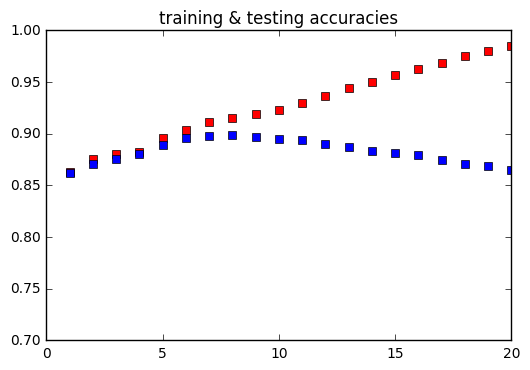

In [19]:
plt.axis([0, 20, 0.7, 1])
plt.plot(max_depths, training_accuracies, 'rs', max_depths, testing_accuracies, 'bs')
plt.title('training & testing accuracies')
plt.show()

** B.6 Based on the plot, identify the following values: ** <br>

- maximum depth(s) for which the decision tree is underfitting
- maximum depth(s) for which the decision tree is overfitting
- optimal maximum depth

- Optimal depth could be be 6 or 7.
- max_depths below the optimal depth is underfitting
- depths above optimal depth are overfitting

** B.7 Train a decision tree on the training sample **

- using the optimal maximum depth identified in B.6
- using entropy to measure the quality of a split
- requiring at least 0.5% of the sample to split an internal node

In [27]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=0.5)
clf_fit = clf.fit(features_train, target_train)

** B.8 Use that tree to predict output values on the testing sample ** <br>
print first 100 predictions

In [28]:
predictions = clf_fit.predict(features_test)
print predictions[0:100]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]


** B.9 Evaluate accuracy of this prediction ** <br>
print the result

In [29]:
testing_accuracy = clf_fit.score(features_test, target_test)
print testing_accuracy

0.898650740987


### C. Train and evaluate support vector machine classifiers

**C.1 Train a non linear SVM on training sample**

- with a penalty parameter C of 1
- a gamma value of 10

In [17]:
%%time
svc = svm.SVC(C=1, gamma=10)
svc_fit = svc.fit(features_train, target_train)

CPU times: user 5min 14s, sys: 3min 13s, total: 8min 28s
Wall time: 10min 38s


**C.2 Comment processing time of training a non linear SVM on a sample of this size **

The training time is very high as compared to the decision tree training time

### D. Train and evaluate k-nearest neighbors classifiers

**D.1 Train a k-nearest neighbors on training sample**

- using 1 nearest neighbor

In [8]:
clf = KNeighborsClassifier(n_neighbors=1)
clf_fit = clf.fit(features_train, target_train)

**D.2 Compute predictive accuracy on training and testing samples for the KNN with 1 nearest neighbor**

In [9]:
training_accuracy = clf_fit.score(features_train, target_train)
testing_accuracy = clf_fit.score(features_test, target_test)
print training_accuracy
print testing_accuracy

1.0
0.815262110153


**D.3 Compare training and testing accuracies**

Training accuracy is exactly 1 and larger than the testing accuracy

**D.4 Explain why training accuracy for a KNN with 1 nearest neighbor is high**

Overfitting. Small values of k turns to overfit the model

** D.5 Complete the following code to evaluate KNN predictive accuracy over complexity ** <br>

- train several KNNs with number of nearest neighbors from 1 to 20
- compute both training and testing accuracies for each number of nearest neighbors and store them in lists

In [12]:
kneighboors = [i+1 for i in range(20)]
training_accuracies = []
testing_accuracies = []
training_precisions = []
testing_precisions = []

for kneighboor in kneighboors:
    
    clf = KNeighborsClassifier(n_neighbors=kneighboor)
    clf_fit = clf.fit(features_train, target_train)
    
    prediction_training = clf_fit.predict(features_train)
    training_accuracy = clf_fit.score(features_train, target_train)
    training_accuracies.append(training_accuracy)
    
    prediction_testing = clf_fit.predict(features_test)
    testing_accuracy = clf_fit.score(features_test, target_test)
    testing_accuracies.append(testing_accuracy)

** Run the following lines to plot training and testing accuracies over number of nearest neighbors ** <br>

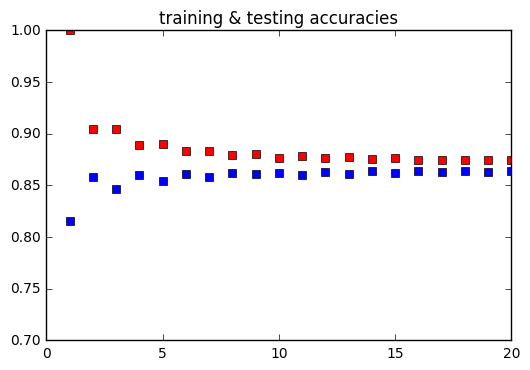

In [13]:
import matplotlib.pyplot as plt
plt.axis([0, 20, 0.7, 1])
plt.plot(kneighboors, training_accuracies, 'rs', kneighboors, testing_accuracies, 'bs')
plt.title('training & testing accuracies')
plt.show()

** D.6 Based on the plot, identify the following values: ** <br>

- number of nearest neighbors for which the KNN is underfitting
- number of nearest neighbors for which the KNN is overfitting
- optimal number of nearest neighbors

- Overfitting: 1 to 5
- Underfitting: 7 to 20
- Optimal: 6

** D.7 Train a KNN on the training sample **

- using the optimal number of nearest neighbors identified in D.6

In [14]:
clf = KNeighborsClassifier(n_neighbors=6)
clf_fit = clf.fit(features_train, target_train)

** D.8 Use that knn to predict output values on the testing sample ** <br>
print first 100 predictions

In [15]:
predictions = clf_fit.predict(features_test)
print predictions[0:100]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


** D.9 Evaluate accuracy of this prediction ** <br>
print the result

In [16]:
testing_accuracy = clf_fit.score(features_test, target_test)
print testing_accuracy

0.861358106614


### E. Predict clients that are the most likely to subscribe to a term deposit

** E.1 Compare decision tree, support vector machine and k-nearest neighbors classifiers on: ** <br>

- predictive accuracy (testing accuracy of optimal complexity)
- processing time ('affordable' or 'not affordable')
- ability to estimate class probability for a new observation ('yes', 'no')

**Decision tree classifiers**

- predictive accuracy: ...
- processing time: ...
- can output class probability: ...

**Support vector machine classifiers (non linear)**

- predictive accuracy: ...
- processing time: ...
- can output class probability: ...

**K-nearest neighbors classifiers**

- predictive accuracy: ...
- processing time: ...
- can output class probability: ...

** E.2 Based on this comparaison, which classifier would you choose to estimate probability to subscribe to a term deposit ?** <br>

** E.3 Use this classifier to estimate probability to subscribe a term deposit for each client from the testing sample: ** <br>
print first 100 class probabilities

In [18]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=0.5)
clf_fit = clf.fit(features_train, target_train)
class_probability = clf_fit.predict_proba(features_test)
print class_probability[0:100]

[[ 0.98537477  0.01462523]
 [ 0.98537477  0.01462523]
 [ 0.98537477  0.01462523]
 [ 0.97665975  0.02334025]
 [ 0.99477807  0.00522193]
 [ 0.98537477  0.01462523]
 [ 1.          0.        ]
 [ 0.97665975  0.02334025]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 0.97665975  0.02334025]
 [ 0.97665975  0.02334025]
 [ 0.97665975  0.02334025]
 [ 0.98537477  0.01462523]
 [ 0.97665975  0.02334025]
 [ 0.97665975  0.02334025]
 [ 0.97665975  0.02334025]
 [ 0.97665975  0.02334025]
 [ 0.47692308  0.52307692]
 [ 0.98537477  0.01462523]
 [ 0.97665975  0.02334025]
 [ 0.47692308  0.52307692]
 [ 0.97665975  0.02334025]
 [ 0.97665975  0.02334025]
 [ 0.97665975  0.02334025]
 [ 0.97665975  0.02334025]
 [ 0.45483871  0.54516129]
 [ 0.90413943  0.09586057]
 [ 0.99477807  0.00522193]
 [ 0.47692308  0.52307692]
 [ 0.45483871  0.54516129]
 [ 0.97665975  0.02334025]
 [ 1.          0.        ]
 [ 0.97665975  0.02334025]
 [ 0.96888889  0.03111111]
 [ 0.97665975  0.02334025]
 [ 0.97665975  0.02334025]
 

** E.4 Compute precision and recall of this classifier on the testing sample** <br>
Print the results <br>

In [22]:
prediction_testing = clf_fit.predict(features_test)
testing_precision = precision_score(target_test,prediction_testing )
testing_recall = recall_score(target_test,prediction_testing )
print testing_precision
print testing_recall

0.68161634103
0.492302758178


** E.5 interpret precision and accuracy of the prediction** <br>